# Prepare Dataset

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# sys.path.insert(0,"..")
from dataloader import dataloader
#device = torch.device("cuda")
tmp = dataloader(r"..\data\clover")
imu, rotor, mocap = tmp.runPipeline()
tmp.homogenizeData()
data = tmp.ConcatData
#print(device)


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO]  Data folder c:\Users\prana\Documents\DeepIO\data\clover\New folder\New folder\rosbag already exists. Not creating.


100%|██████████| 1/1 [00:15<00:00, 15.26s/it]


In [2]:
data['g_x'] = 0.0
data['g_y'] = 0.0
data['g_z'] = -9.81


In [76]:
sensor_readings = data[['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z',
                        'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'g_x', 'g_y', 'g_z','theta', 'pose.position.z', 'psi']].to_numpy()
sensor_readings = torch.tensor(sensor_readings,dtype=torch.float32)#, device=device)
sensor_readings = sensor_readings[:100000,:]
sensor_readings.shape


torch.Size([100000, 12])

In [77]:
#eulers = data[['phi', 'theta', 'psi']].to_numpy()
pos_estimate = data[['pose.position.x', 'phi', 'pose.position.y']].to_numpy()
pos_estimate = torch.tensor(pos_estimate,dtype=torch.float32)#, device=device)
pos_estimate = pos_estimate[:100000,:]


# Neural net architectures

FNN

In [78]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(12, 30, dtype=torch.float32)
        self.layer2 = nn.Linear(30, 30, dtype=torch.float32)
        self.layer3 = nn.Linear(30, 3, dtype=torch.float32)
        self.tanh = nn.Tanh()

    def forward(self, sensor_reading):
        x = self.tanh(self.layer1(sensor_reading))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

RNN

In [80]:
import tensorflow as tf

GRUNet = tf.keras.models.Sequential([tf.keras.layers.Input((12, 1)),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.GRU(128),
                    tf.keras.layers.Dropout(0.45),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(3)])

LSTMNet = tf.keras.models.Sequential([tf.keras.layers.Input((12, 1)),
                    tf.keras.layers.LSTM(128,activation='relu'),
                    tf.keras.layers.Dropout(0.45),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(3)])

SimpleRNNNet = tf.keras.models.Sequential([tf.keras.layers.Input((12, 1)),
                    tf.keras.layers.SimpleRNN(128,activation='relu'),
                    tf.keras.layers.Dropout(0.45),
                    tf.keras.layers.Dense(32, activation='relu'),     
                    tf.keras.layers.Dense(3)])

CNN

In [20]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.call = nn.Sequential(

            nn.Conv1d(9, 32, kernel_size=1),#, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),

            nn.Conv1d(32, 64, kernel_size=1),#, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.4),

            #nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 6)
        )
        self.call = self.call.float()

    def forward(self, x):
        x = x.reshape(-1, 9, 1)
        x = self.call(x)
        return x

# Training Neural nets

In [69]:
# Use for FNN, CNN
def TrainModel(Model, sensor_readings, pos_estimates, lr=0.01, epochs=250):

    dataset = torch.utils.data.TensorDataset(sensor_readings, pos_estimates)
    train_set, test_set = torch.utils.data.random_split( dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
    optimizer = torch.optim.Adam(Model.parameters(), lr=lr)
    dataloader = torch.utils.data.DataLoader(train_set, batch_size=5000, shuffle=True)
    loss_fn = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        for batch in dataloader:
            sensor_reading, pos_estimate = batch
            prediction = Model(sensor_reading)
            loss = loss_fn(prediction, pos_estimate)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if epoch % 25 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    return Model, losses

# Use for RNN
def TrainModelTF(Model, sensor_readings, pos_estimates, lr=0.001, epochs=250):

    SensorTF = tf.convert_to_tensor(sensor_readings, dtype=tf.float32)
    posTF = tf.convert_to_tensor(pos_estimates, dtype=tf.float32)
    Model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=lr), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = Model.fit(SensorTF[:95000,:], posTF[:95000,:], validation_data=(SensorTF[95000:,:], posTF[95000:,:]), epochs=epochs)
    
    return SensorTF, posTF, history, Model

Epoch: 0, Loss: 2.3779115676879883
Epoch: 25, Loss: 1.3165963888168335
Epoch: 50, Loss: 1.054969310760498
Epoch: 75, Loss: 0.9556834101676941
Epoch: 100, Loss: 0.8928741812705994
Epoch: 125, Loss: 0.8489842414855957
Epoch: 150, Loss: 0.798888623714447
Epoch: 175, Loss: 0.7672640681266785
Epoch: 200, Loss: 0.7164193391799927
Epoch: 225, Loss: 0.6889249086380005
Epoch: 250, Loss: 0.6656509041786194
Epoch: 275, Loss: 0.6244994401931763
Epoch: 300, Loss: 0.6141305565834045
Epoch: 325, Loss: 0.6026866436004639
Epoch: 350, Loss: 0.5450178384780884
Epoch: 375, Loss: 0.5648640394210815
Epoch: 400, Loss: 0.5499778389930725
Epoch: 425, Loss: 0.5516447424888611
Epoch: 450, Loss: 0.5266785025596619
Epoch: 475, Loss: 0.49810394644737244


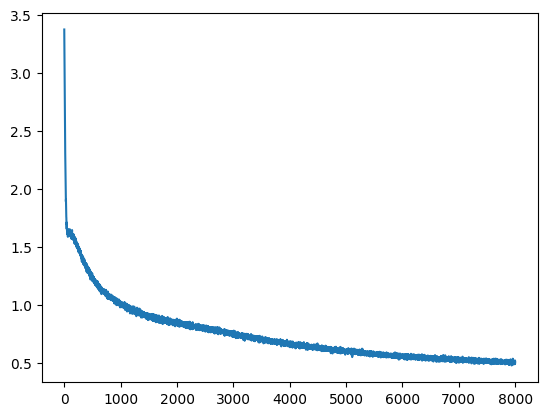

In [26]:
FNNNet = FNN()#.to(device)
FNNModel, LossHistoryFNN = TrainModel(FNNNet, sensor_readings, pos_estimate, lr=0.001, epochs=500)

plt.plot(LossHistoryFNN)
plt.show()

Epoch 1/50
2969/2969 [==============================] - 19s 6ms/step - loss: 2.0551 - root_mean_squared_error: 1.4336 - val_loss: 2.3005 - val_root_mean_squared_error: 1.5167
Epoch 2/50
2969/2969 [==============================] - 17s 6ms/step - loss: 1.1360 - root_mean_squared_error: 1.0658 - val_loss: 1.5277 - val_root_mean_squared_error: 1.2360
Epoch 3/50
2969/2969 [==============================] - 19s 7ms/step - loss: 0.7100 - root_mean_squared_error: 0.8426 - val_loss: 1.1343 - val_root_mean_squared_error: 1.0650
Epoch 4/50
2969/2969 [==============================] - 19s 7ms/step - loss: 0.5130 - root_mean_squared_error: 0.7163 - val_loss: 0.9359 - val_root_mean_squared_error: 0.9674
Epoch 5/50
2969/2969 [==============================] - 19s 7ms/step - loss: 0.4073 - root_mean_squared_error: 0.6382 - val_loss: 0.6833 - val_root_mean_squared_error: 0.8266
Epoch 6/50
2969/2969 [==============================] - 19s 7ms/step - loss: 0.3461 - root_mean_squared_error: 0.5883 - val_l

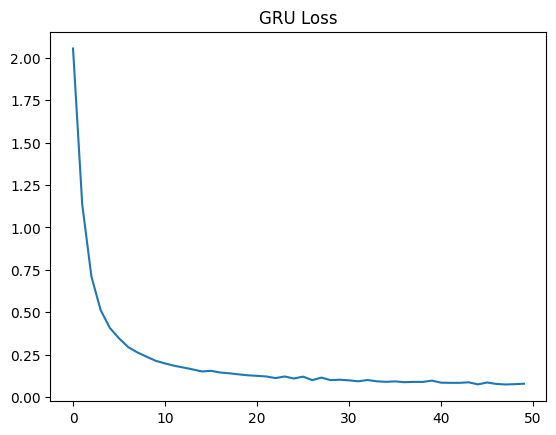

In [81]:
SensorTF, posTF, LossHistoryGRU, GRUModel = TrainModelTF(GRUNet, sensor_readings, pos_estimate, lr=0.2, epochs=50)

plt.plot(LossHistoryGRU.history['loss'])
plt.title('GRU Loss')
plt.show()

# Scientific Deep learning methods

Tried DeepOnet for operator learning, PFNN, NODE, Multi fidelity and other scientific deep learning methods but couldnt get good results

In [ ]:
X_train, y_train = sensor_readings[:60000,:].numpy(), pos_estimate[:60000,:].numpy()
X_test, y_test = sensor_readings[60000:,:].numpy(), pos_estimate[60000:,:].numpy()

import deepxde as dde
Data = dde.data.DataSet(X_train, y_train, X_test, y_test)

Resnet = dde.nn.ResNet(9,3,128*3, 5,activation = "tanh", kernel_initializer="Glorot normal")
PFNNnet = dde.nn.PFNN([[30,30,1],[30,30,1],[30,30,1]], activation = "tanh", kernel_initializer="Glorot normal")

model = dde.Model(Data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)


In [ ]:
class euler_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 30)
        self.layer2 = nn.Linear(30, 30)
        self.layer3 = nn.Linear(30, 3)
        self.tanh = nn.Tanh()

    def forward(self, sensor_reading):
        x = self.tanh(self.layer1(sensor_reading))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(9, 35),
            nn.LeakyReLU(),
            nn.Linear(35, 35),
            nn.LeakyReLU(),
            nn.Linear(35, 3),
        )
        #self.net = self.net.float()
        self.net.apply(self._apply_wt_init)

    def forward(self, t, y):
        print(y.dtype)
        return self.net(y)
    
    def _apply_wt_init(self, layer):
        if isinstance(layer, nn.Linear):
            print(layer.weight.dtype)
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, val=0)
              
m = 100
dim_x = 9
net = dde.nn.deeponet.DeepONet(
    (100, euler_model()),
    [9, 30,30,3], 
    "relu",
    "Glorot normal",
)

NODEModel = ODEFunc()#.to(device)

#Define a Model
model = dde.Model(Data, net)

# Compile and Train
model.compile("adam", lr=0.0005, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=50000)


In [ ]:
from torchdiffeq import odeint_adjoint as odeint
def CreateBatch(yTrain, xTrain, size, batch_size, batch_time):
        
    s = torch.from_numpy(np.random.choice(np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = yTrain[s,:]
    batch_x = np.array([0,1])#xTrain[:batch_time] 
    batch_y = xTrain[s,:]#torch.stack([torch.Tensor(yTrain[s + i,:]) for i in range(batch_time)], dim=0)

    return batch_y0, batch_x, batch_y

lr = 0.01
dataset = torch.utils.data.TensorDataset(sensor_readings, eulers)
train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
optimizer = torch.optim.Adam(EulerModel.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=10000, shuffle=True)
loss_fn = nn.MSELoss()
losses = []

epoch_num = 1000
# axa,y,az,gx,-9.81
for epoch in range(epoch_num):
    #for batch in dataloader:
    #sensor_reading, euler = batch
    t = np.array([0,1])

    batch_y0, batch_x, batch_y = CreateBatch(sensor_reading, eulers, np.shape(sensor_reading)[0], 1000, 2)
    pred_y = odeint(EulerModel, torch.Tensor(batch_y0).to(torch.float64), torch.Tensor(batch_x), method='dopri5')
        
    loss = torch.mean(torch.abs(pred_y - batch_y))

        #loss = loss_fn(prediction, eulers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

fig = plt.figure()
plt.plot(losses)
plt.show()

# Results

In [85]:
def PlotPOSResults(sensor_readings, pos_estimates, Model):

    #Model.eval()
    with torch.no_grad():
        prediction = Model(sensor_readings)

    fig, axs = plt.subplots(3, 1, figsize=(15, 8))

    axs[0].plot(prediction[:, 0].cpu().numpy(), label='FNN Predicted')
    axs[0].plot(pos_estimates[:, 0].cpu().numpy(), label='Actual')
    axs[0].set_title('Position X')
    axs[0].legend()

    axs[1].plot(prediction[:, 1].cpu().numpy(), label='FNN Predicted')
    axs[1].plot(pos_estimates[:, 1].cpu().numpy(), label='Actual')
    axs[1].set_title('Position Y')
    axs[1].legend()

    axs[2].plot(prediction[:, 2].cpu().numpy(), label='FNN Predicted')
    axs[2].plot(pos_estimates[:, 2].cpu().numpy(), label='Actual')
    axs[2].set_title('Position Z')
    axs[2].legend()
    
    plt.show()

def PlotOrientResults(sensor_readings, pos_estimates, Model):

    #Model.eval()
    with torch.no_grad():
        prediction = Model(sensor_readings)

    fig, axs = plt.subplots(3, 1, figsize=(15, 8))

    axs[0].plot(prediction[:, 1].cpu().numpy(), label='FNN Predicted')
    axs[0].plot(pos_estimates[:, 1].cpu().numpy(), label='Actual')
    axs[0].set_title('Roll')
    axs[0].legend()

    axs[1].plot(prediction[:, 3].cpu().numpy(), label='FNN Predicted')
    axs[1].plot(pos_estimates[:, 3].cpu().numpy(), label='Actual')
    axs[1].set_title('Pitch')
    axs[1].legend()

    axs[2].plot(prediction[:, 5].cpu().numpy(), label='FNN Predicted')
    axs[2].plot(pos_estimates[:, 5].cpu().numpy(), label='Actual')
    axs[2].set_title('Yaw')
    axs[2].legend()

    plt.show()

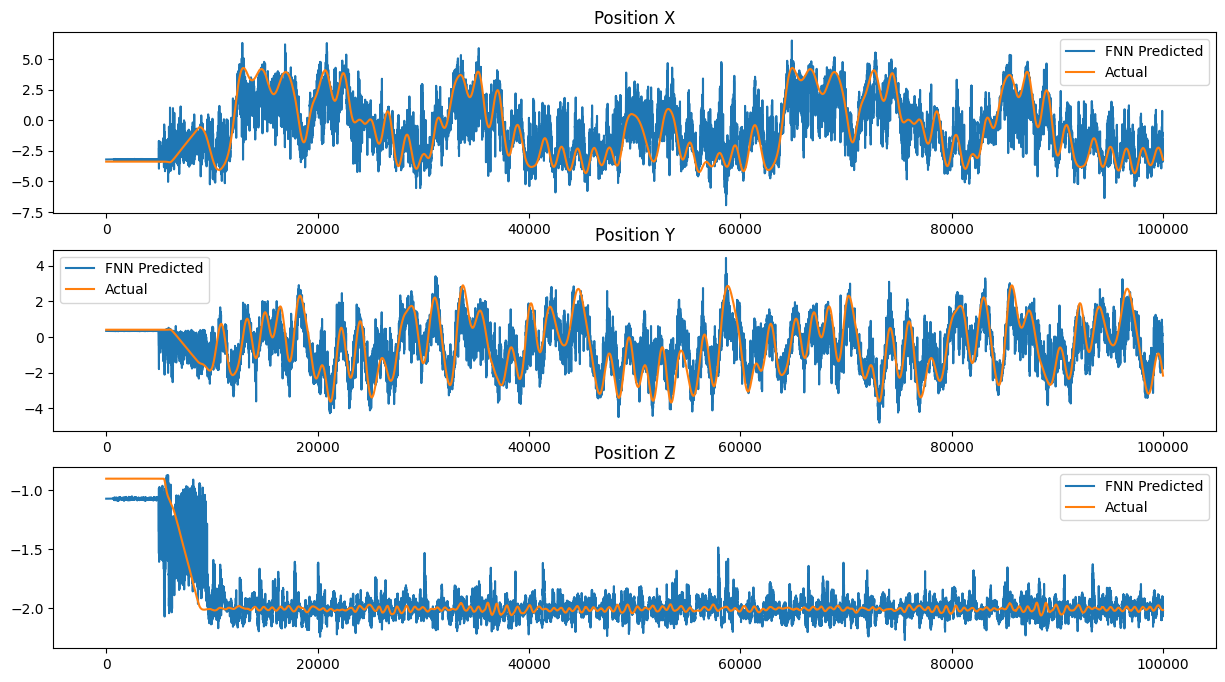

In [72]:
PlotPOSResults(sensor_readings, pos_estimate, FNNModel)

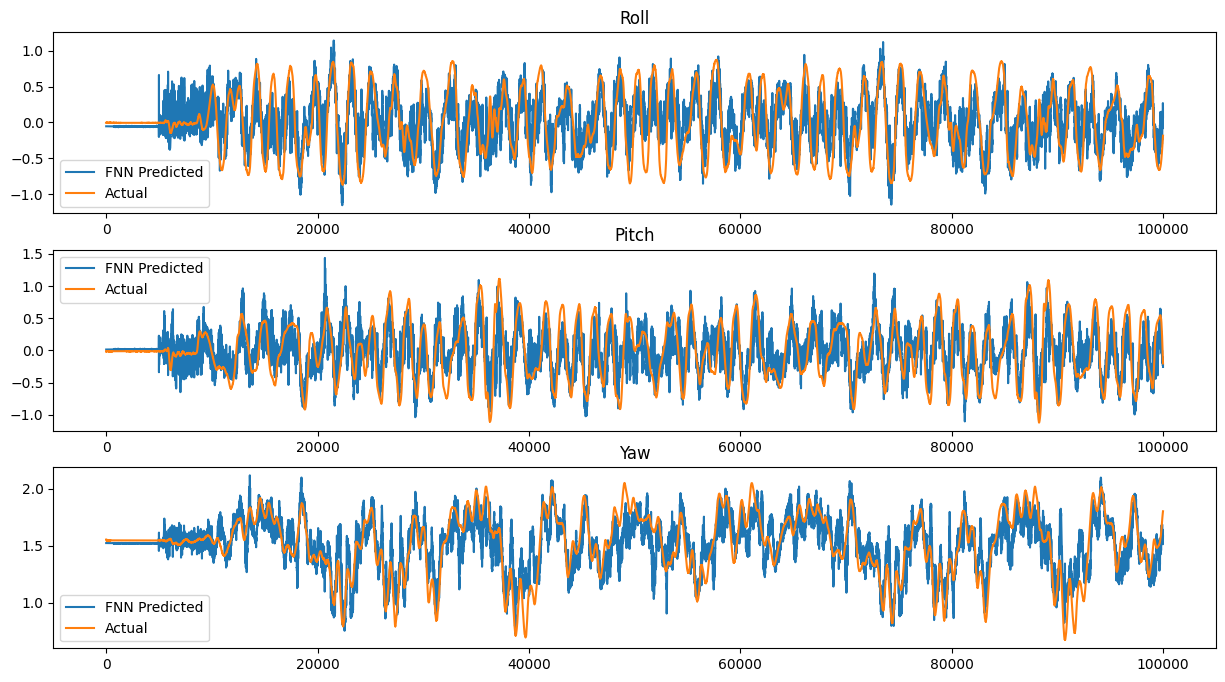

In [73]:
PlotOrientResults(sensor_readings, pos_estimate, FNNModel)

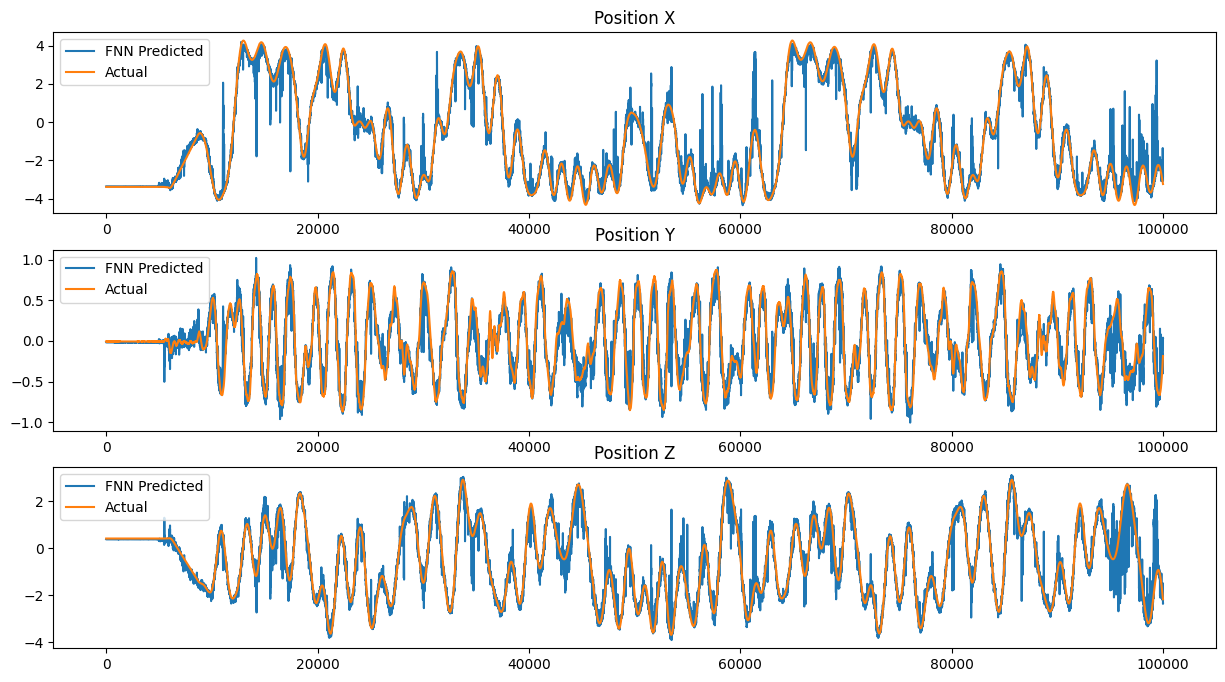

In [86]:
PlotPOSResults(SensorTF, posTF, GRUModel)

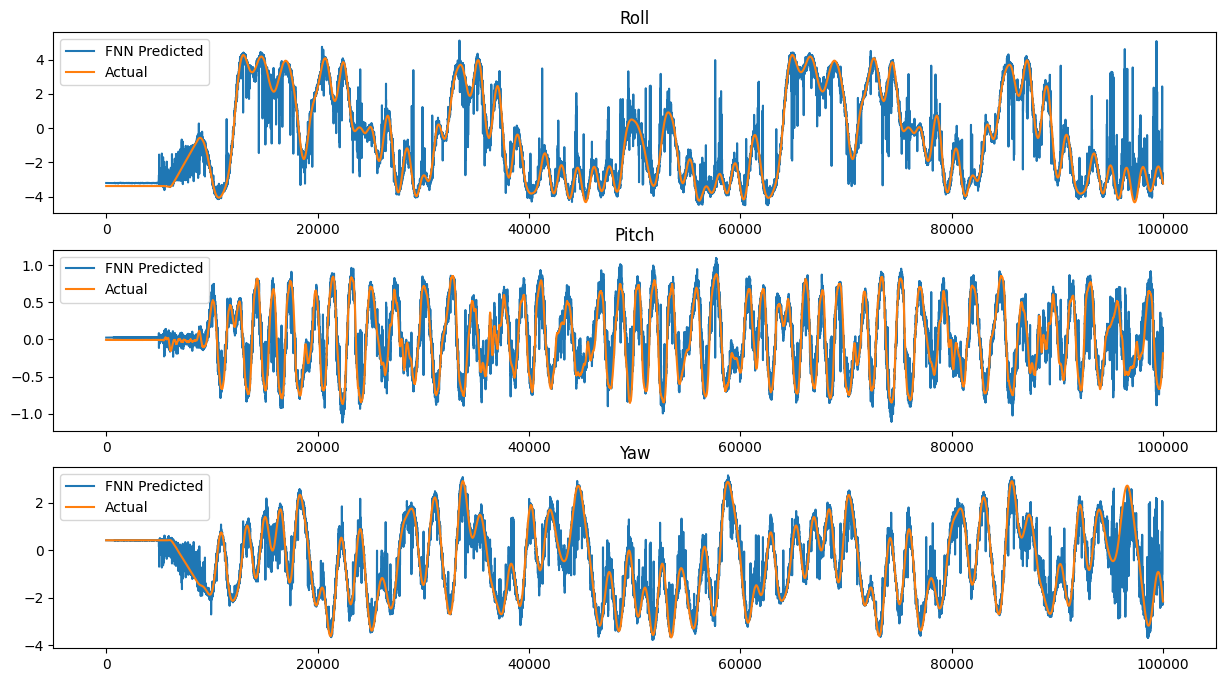

In [65]:
PlotOrientResults(SensorTF, posTF, GRUModel)

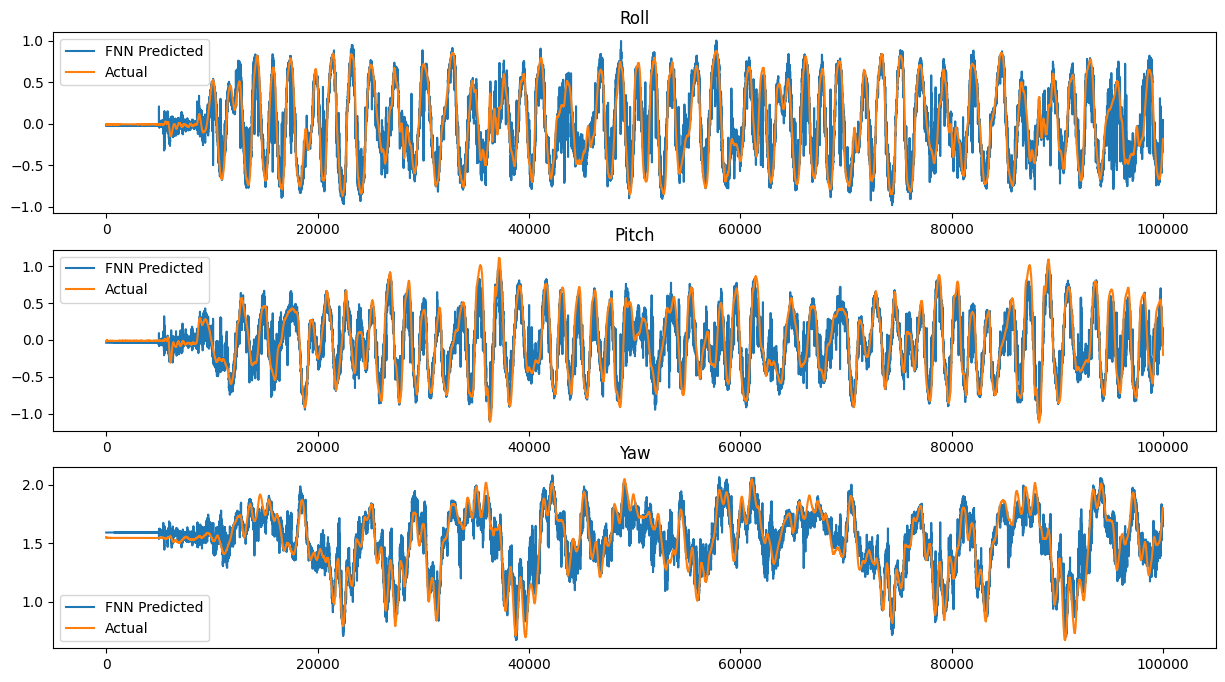

In [75]:
PlotOrientResults(SensorTF, posTF, GRUModel)

# SCRAP

In [ ]:
# import matplotlib.pyplot as plt


# x1, y1, z1 = data['pose.position.x'].to_numpy(
# ), data['pose.position.y'].to_numpy(), data['pose.position.z'].to_numpy()
# xA1, yA1, zA1 = data['psi'].to_numpy(
# ), data['theta'].to_numpy(), data['phi'].to_numpy()
# dt = np.append(0, np.diff(data['Time'].to_numpy()))
# r1, r2, r3, r4 = data['rpm_0'].to_numpy(), data['rpm_1'].to_numpy(
# ), data['rpm_2'].to_numpy(), data['rpm_3'].to_numpy()


# TrajectorySize = 25000  # 15*350
# TrainTrajectorySize = int(0.8*TrajectorySize)
# St = 0  # Start index


# xTrain = np.stack((r1[St:St + TrajectorySize], r2[St:St + TrajectorySize],
#                   r3[St:St + TrajectorySize], r4[St:St + TrajectorySize], dt[St:St + TrajectorySize]), axis=1)
# yTrain = np.stack((x1[St:St + TrajectorySize], y1[St:St + TrajectorySize], z1[St:St + TrajectorySize],
#                    xA1[St:St + TrajectorySize], yA1[St:St + TrajectorySize], zA1[St:St + TrajectorySize]), axis=1)


# # torch.tensor(xTrain[:7000], dtype=torch.float32)
# train_x = xTrain[:TrainTrajectorySize]
# # torch.tensor(yTrain[:7000], dtype=torch.float32)
# train_y = yTrain[:TrainTrajectorySize]
# # torch.tensor(xTrain[7000:], dtype=torch.float32)
# test_x = xTrain[TrainTrajectorySize:]
# # torch.tensor(yTrain[7000:], dtype=torch.float32)
# test_y = yTrain[TrainTrajectorySize:]

# xTrain = torch.tensor(xTrain, device=device)
# yTrain = torch.tensor(yTrain, device=device)
# train_x = torch.tensor(train_x, device=device)
# train_y = torch.tensor(train_y, device=device)
# test_x = torch.tensor(test_x, device=device)
# test_y = torch.tensor(test_y, device=device)

# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[:, 0].cpu().numpy(), train_y[:, 1].cpu(
# ).numpy(), train_y[:, 2].cpu().numpy(), '.b')


In [ ]:
# #### NODE #####

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchdiffeq import odeint_adjoint as odeint
# import numpy as np
# import matplotlib.pyplot as plt

# method = 'dopri5'
# batch_time = 45
# batch_size = TrainTrajectorySize-100
# niters = 200000
# test_freq = 10000
# viz = 'store_true'
# adjoint = 'store_true'


# # def mini_batch(yTrain, xTrain, size, batch_size, batch_time):

# #     s = torch.from_numpy(np.random.choice(
# #         np.arange(size-batch_time, dtype=np.int64), batch_size, replace=False))
# #     batch_y0 = xTrain[s, :4]
# #     batch_x = xTrain[:batch_time, 4]
# #     batch_y = torch.stack([torch.Tensor(xTrain[s + i, :4])
# #                           for i in range(batch_time)], dim=0)
# #     batch_yy = yTrain[s, :]
# #     batch_yy1 = yTrain[s+1, :]

# #     return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

# def mini_batch(yTrain, xTrain, size, batch_size, batch_time):
#     device = torch.device("cuda")
#     s = torch.randint(0, size-batch_time, (batch_size,),
#                       dtype=torch.int64, device=device)
#     batch_y0 = xTrain[s, :4]
#     batch_x = xTrain[:batch_time, 4]
#     batch_y = torch.stack([xTrain[s + i, :4]
#                           for i in range(batch_time)], dim=0)
#     batch_yy = yTrain[s, :]
#     batch_yy1 = yTrain[s+1, :]

#     return batch_y0, batch_x, batch_y, batch_yy, batch_yy1

# # def TrainNODENetwork(yTrain, xTrain, size, batch_size, batch_time, FuncControl, FuncDynamics, niters=13000,):

# #     parameters = list(FuncControl.parameters()) + \
# #         list(FuncDynamics.parameters())
# #     # optimizerD = optim.Adam(params=parameters, lr=1e-3)
# #     optimizer = optim.Adadelta(
# #         params=parameters, lr=1, rho=0.9, eps=1e-06, weight_decay=0)

# #     for itr in range(1, niters + 1):
# #         optimizer.zero_grad()
# #         batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
# #             yTrain, xTrain, size, batch_size, batch_time)
# #         # pred_y = odeint(FuncControl, torch.Tensor(
# #             # batch_y0).to(device = 'cuda:0'), torch.Tensor(batch_x))

# #         XDynamics = torch.cat((batch_y0, batch_yy), 1).to(
# #             device='cuda:0')  # pred_y[1,:,:]
# #         pred_yy = FuncDynamics(XDynamics).to(device='cuda:0', dtype=torch.float64)
# #         lossD = torch.mean(
# #             torch.abs(pred_yy - batch_yy1))
# #         # lossC = torch.mean(torch.abs(pred_y - torch.Tensor(batch_y)))

# #         loss = lossD  # + lossC
# #         loss.backward()
# #         optimizer.step()

# #         if itr % test_freq == 0:
# #             '''with torch.no_grad():
# #                 pred_y = odeint(Func, torch.Tensor(y0[1,:]), t)
# #                 loss = torch.norm(pred_y - torch.Tensor(y[:,1,:]))'''
# #             print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

# #     return FuncControl, FuncDynamics


# class ODEFunc(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(4, 30),
#             nn.ReLU(),
#             nn.Linear(30, 30),
#             nn.ReLU(),
#             nn.Linear(30, 4),
#         )
#         self.net = self.net.float()
#         self.net.apply(self._apply_wt_init)

#     def forward(self, t, y):
#         return self.net(y)

#     def _apply_wt_init(self, layer):
#         if isinstance(layer, nn.Linear):
#             nn.init.normal_(layer.weight, mean=0, std=0.1)
#             nn.init.constant_(layer.bias, val=0)


# class Func2(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             # nn.BatchNorm1d(10),
#             nn.Linear(10, 175),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(175),
#             nn.Linear(175, 35),
#             nn.LeakyReLU(),
#             nn.BatchNorm1d(35),
#             nn.Linear(35, 6),
#         )
#         self.net = self.net.to(dtype=torch.float64)
#         self.net.apply(self._apply_wt_init)

#     def forward(self, y):
#         return self.net(y)

#     def _apply_wt_init(self, layer):
#         if isinstance(layer, nn.Linear):
#             nn.init.normal_(layer.weight, mean=0, std=0.1)
#             nn.init.constant_(layer.bias, val=0)


# FuncControl = ODEFunc().to(device=device)
# FuncDynamics = Func2().to(device=device)

# train_y = torch.tensor(train_y, device=device)
# train_x = torch.tensor(train_x, device=device)


# # FuncControl, FuncDynamics = TrainNODENetwork(
# #     train_y, train_x, TrainTrajectorySize, batch_size, batch_time, FuncControl, FuncDynamics)


In [ ]:
# parameters = list(FuncControl.parameters()) + list(FuncDynamics.parameters())
# optimizer = optim.Adadelta(params=parameters, lr=0.1,
#                            rho=0.9, eps=1e-06, weight_decay=0)

# batchy0s = []
# batchxs = []
# batchys = []
# batchyys = []
# batchyy1s = []

# # for itr in range(1, niters + 1):
# #     batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
# #         yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)
# #     batchy0s.append(batch_y0)
# #     batchxs.append(batch_x)
# #     batchys.append(batch_y)
# #     batchyys.append(batch_yy)
# #     batchyy1s.append(batch_yy1)
# niters = 5000
# test_freq = 1000
# for itr in range(1, niters + 1):
#     optimizer.zero_grad()
#     # batch_y0 = batchy0s[itr-1]
#     # batch_x = batchxs[itr-1]
#     # batch_y = batchys[itr-1]
#     # batch_yy = batchyys[itr-1]
#     # batch_yy1 = batchyy1s[itr-1]

#     batch_y0, batch_x, batch_y, batch_yy, batch_yy1 = mini_batch(
#         yTrain, xTrain, TrainTrajectorySize, batch_size, batch_time)

#     XDynamics = torch.cat([batch_y0, batch_yy], dim=1)
#     pred_yy = FuncDynamics(XDynamics)
#     loss = torch.mean(torch.abs(pred_yy - batch_yy1))

#     loss.backward()
#     optimizer.step()

#     if itr % test_freq == 0:
#         print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))


In [ ]:
# from copy import deepcopy


In [ ]:
# %matplotlib widget
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
# ).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     if i % 500 == 0:
#         m = deepcopy(train_y[i, :])

#         # m[0] += (np.random.uniform()-0.5)
#         # m[1] += (np.random.uniform()-0.5)
#         # m[2] += (np.random.uniform()-0.5)
#     else:
#         m = pred_y
#     # print("In",m)
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = FuncDynamics(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     # print("Out:", y0)
#     # if i == 5:
#     #     break
#     x.append(y0[0])
#     y.append(y0[1])
#     z.append(y0[2])

# ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
# plt.gca().set_zlim([-5, 0])
# plt.show()


In [ ]:
# %matplotlib widget
# plt.figure()
# xt = []
# yt = []
# zt = []

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))

#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     if i % 500 == 0:
#         m = deepcopy(train_y[i, :])

#         # m[0] += (np.random.uniform()-0.5)
#         # m[1] += (np.random.uniform()-0.5)
#         # m[2] += (np.random.uniform()-0.5)
#     else:
#         m = pred_y
#     # print("In",m)
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = FuncDynamics(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     y0[3:] = np.arctan2(np.sin(y0[3:]), np.cos(y0[3:]))
#     # print("Out:", y0)
#     # if i == 5:
#     #     break
#     x.append(y0[3])
#     y.append(y0[4])
#     z.append(y0[5])
#     xt.append(train_y[i, 3].cpu().detach().numpy())
#     yt.append(train_y[i, 4].cpu().detach().numpy())
#     zt.append(train_y[i, 5].cpu().detach().numpy())

# plt.plot(np.array(xt)*10, 'r')
# plt.plot(x, 'b')


# plt.show()


In [ ]:
# plt.figure()
# plt.plot(yt, 'r')
# plt.plot(y, 'b')
# plt.show()


In [ ]:
# plt.figure()
# plt.plot(yt, 'r')
# plt.plot(y, 'b')
# plt.show()


In [ ]:
# torch.save(FuncDynamics.state_dict(), 'FuncDynamics2.pt')


In [ ]:
# loadModel = Func2().to(device=device)


In [ ]:
# loadModel.load_state_dict(torch.load('FuncDynamics.pt'))


In [ ]:
# loadModel.eval()
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(train_y[::2, 0].cpu().detach().numpy(), train_y[::2, 1].cpu(
# ).detach().numpy(), train_y[::2, 2].cpu().detach().numpy(), '.r')

# y0 = train_y[0, :]
# u0 = train_x[0, :4]
# FuncDynamics.eval()
# x = []
# y = []
# z = []
# for i in range(TrainTrajectorySize):

#     # pred_u = odeint(FuncControl, torch.Tensor(u0), torch.Tensor(train_x[i:i+5,4]))
#     u0 = train_x[i, :4]  # pred_u[1,:].detach().numpy()
#     m = deepcopy(train_y[i, :])
#     m[0] += (np.random.uniform()-0.5)*3
#     m[1] += (np.random.uniform()-0.5)*3
#     m[2] += (np.random.uniform()-0.5)*3
#     XDynamics = torch.cat(
#         (torch.Tensor(u0), torch.Tensor(m).to(device='cuda:0'))).to(device='cuda:0').unsqueeze(0)
#     pred_y = loadModel(XDynamics).flatten()
#     y0 = pred_y.to('cpu').detach().numpy()
#     x.append(y0[0])
#     y.append(y0[1])
#     z.append(y0[2])

# ax.scatter(x[0::2], y[::2], z[::2], s=8, c='b')
# plt.xlim([-5, 5])
# plt.ylim([-5, 5])
# plt.gca().set_zlim([-5, 0])
# plt.show()
